## Load Required Packages & Tools...

In [ ]:
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statistics
import json
import pickle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

work_dir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing/ml_model/'
out_dir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing/heuristic_model/output_data/'

## Read in Training & Test Datasets...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

wdir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing'

train = pd.read_csv(wdir+"/TRAIN.csv")
test = pd.read_csv(wdir+"/TEST.csv")

train.drop(labels="Unnamed: 0",axis=1, inplace=True)
test.drop(labels="Unnamed: 0",axis=1, inplace=True)

print('Number of Posts in Training Set: ' + str(len(train)) + " + Number of Posts in Test Set: " + str(len(test)))

Mounted at /content/drive
Number of Posts in Training Set: 1600 + Number of Posts in Test Set: 401


## Format Data, Allign Classes with Entitites & Tokenize

*   Create a dataset object out of the training and test data
*   First, tokenize all posts into corresponding word pieces (these are given by coordinates where wordpiece1 goes from 0-3 in terms of position and is written as (0,3).
*   For each word piece (e.g (0,3) (3,6)...ect) determine if it is an entity or if it is just an unlabeled span of text
*   If the word piece is part of an entity, label it with the corresponding entity id (e.g no entity = 25 while ADHD = 0 and so on)
*   Returns the id associated with EACH word piece tokens (e.g if a post has 3 word piece tokens [(0,3),(3,6),(6,8)] then the function would determine which of them are part of a word piece: [25, 0, 25])

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00


In [ ]:
import datasets
from datasets import Dataset, DatasetDict

ds_train = Dataset.from_pandas(train)
ds_test = Dataset.from_pandas(test)

ds = DatasetDict()

ds['train'] = ds_train
ds['test'] = ds_test

dataset = ds
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'Non_Medical_Use', 'Withdrawl', 'Tolerance', 'Entities', 'Class', 'Start', 'End'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['ID', 'text', 'Non_Medical_Use', 'Withdrawl', 'Tolerance', 'Entities', 'Class', 'Start', 'End'],
        num_rows: 401
    })
})

In [ ]:
general_classes_to_id = {'Prescription_Stimulants': 0, 'Perscription_Medications': 1, 'OTCs': 2,
                         'Substances': 3, 'Anxiety': 4, 'Depression': 5, 'ADHD': 6, 'Other_Diagnoses': 7, 'WILD': 8}

N_LABELS = len(general_classes_to_id)

classes_to_id = {
    'ADHD': 6,'Adderall': 0,'Anxiety': 4,'Caffeine': 3,'Vyvanse': 0,'Nicotine': 3,'Depression': 5,
    'Anti-Depressants': 1,'Eating_Disorder': 7,'Alcohol': 3,'OCD': 7,'Sleeping_Pills': 2,
    'Benzodiazepines': 1,'Antacids': 2,'Dexedrine': 0,'Focalin': 0,'Supplements': 2,
    'Bipolar': 7,'Ritalin': 0,'Concerta': 0,'Marijuana': 3,'Narcolepsy': 7,
    'Antipsychotic': 1,'Modafinil': 0,'WILD': 8, 'Prescription_Stimulants': 0}

In [ ]:
id_to_classes = {v: k for k, v in general_classes_to_id.items()}
id_to_classes

{0: 'Prescription_Stimulants',
 1: 'Perscription_Medications',
 2: 'OTCs',
 3: 'Substances',
 4: 'Anxiety',
 5: 'Depression',
 6: 'ADHD',
 7: 'Other_Diagnoses',
 8: 'WILD'}

*   res['input_ids'][0] = the list of all integer values corresponding to the tokens in that given post (e.g [4,5,3,2] in ['hi', 'i', ''ve', 'changed'])
*   res['overflow_to_sample_mapping'] = gives the id of the original sentence (where the token belongs in the collection of documents if there are multiple sentences)
*   res['offset_mapping'][0] = the start and end position for a given token

In [ ]:
model_ckpt = 'allenai/longformer-base-4096'
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

MAX_LENGTH = 1024
import ast
def labeling_tokens(sample):
  res = tokenizer(sample['text'], padding=True, return_offsets_mapping=True, truncation=True, max_length=MAX_LENGTH, return_overflowing_tokens=True)

  sample_mapping = res['overflow_to_sample_mapping']

  # maps each token to the chars in the string
  offset_mapping = res['offset_mapping']

  res["labels"] = []

  #print(sample_mapping)
  for i in range(len(offset_mapping)):
    s_index = sample_mapping[i]
    # Initialize labels array with WILD (ie no entity)
    labels = [classes_to_id["WILD"] for k in range(len(res['input_ids'][i]))] # number of tokens

    # label_start=start position of a given labeled entity (eg 499)
    # label_end=end position of a given labeled entity (eg 503)
    # label=name of the given entity (eg ADHD)
    # loops through each entity contained in the post...

    for label_start, label_end, label in list(zip(ast.literal_eval(sample['Start'][s_index]), ast.literal_eval(sample['End'][s_index]), ast.literal_eval(sample['Class'][s_index]))):

      for j in range(len(labels)):
        token_start = offset_mapping[i][j][0]
        token_end = offset_mapping[i][j][1]

        if token_start == label_start:
          labels[j] = classes_to_id[label]
        if int(token_start) > int(label_start) and int(token_end) <= int(label_end):
          labels[j] = classes_to_id[label]

    res['labels'].append(labels)

  return res

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
tokenized_dataset = dataset.map(labeling_tokens, batched=True, batch_size=10000, remove_columns=dataset['train'].column_names)
# tokenized_dataset['train']['labels'][1] # test to see if the above call worked (most numbers should be 25 but a few should be labeled with a different id to indicte an entity

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

## Create SVM Model

First, read in the tokens associated with each entity and combine them all together to get the total number of unique tokens associated with any labeled entity (these are what I will use as my feature set in the model)...

In [ ]:
class_tokens = json.load(open(out_dir+"entity_id_map_REDUCED.txt"))
class_tokens.keys() # to double check the loading of data worked!

dict_keys(['Prescription_Stimulants', 'Perscription_Medications', 'OTCs', 'Substances', 'Anxiety', 'Depression', 'ADHD', 'Other_Diagnoses', 'WILD'])

In [ ]:
entity_token_ids = []
for entity in class_tokens.keys(): # loop through each entity
  entity_token_ids = entity_token_ids + class_tokens[entity]

# get all UNIQUE tokens from this list! (470 total)
entity_token_ids = set(entity_token_ids)
entity_token_ids = list(entity_token_ids)
# len(entity_token_ids)

In [ ]:
len(entity_token_ids)

470

In [ ]:
entity_token_ids.sort()
# remove numbers 0 because it is the start token and 2 because it is the end token and 1 because it is used for padding!
entity_token_ids = entity_token_ids[3:]
print(entity_token_ids)

[4, 5, 8, 9, 10, 11, 12, 17, 18, 19, 23, 27, 29, 41, 73, 102, 118, 127, 154, 157, 158, 179, 181, 196, 219, 242, 251, 254, 257, 260, 261, 263, 291, 293, 295, 300, 313, 324, 326, 329, 338, 354, 364, 368, 379, 389, 402, 405, 415, 417, 424, 437, 438, 449, 457, 459, 462, 463, 475, 523, 538, 564, 579, 594, 605, 614, 625, 627, 642, 654, 661, 681, 705, 718, 740, 741, 748, 757, 763, 765, 784, 800, 808, 821, 833, 843, 853, 859, 876, 890, 909, 910, 918, 922, 927, 936, 939, 992, 995, 1001, 1007, 1021, 1029, 1043, 1069, 1071, 1073, 1075, 1090, 1115, 1116, 1168, 1178, 1182, 1191, 1198, 1222, 1244, 1250, 1253, 1262, 1264, 1275, 1342, 1344, 1437, 1439, 1475, 1499, 1503, 1506, 1510, 1517, 1606, 1630, 1688, 1690, 1741, 1759, 1809, 1825, 1855, 1879, 1907, 1999, 2001, 2070, 2088, 2137, 2253, 2272, 2329, 2353, 2399, 2440, 2457, 2459, 2462, 2495, 2527, 2538, 2552, 2553, 2569, 2601, 2611, 2900, 2982, 3023, 3055, 3056, 3112, 3140, 3141, 3169, 3206, 3228, 3245, 3267, 3277, 3314, 3335, 3349, 3463, 3501, 3529, 3

In [ ]:
def form_feature_matrix(tokens, ids):

  feature_matrix = np.zeros((len(tokens), len(ids)), dtype=int)
  print("feature matrix initialized with shape " + str(feature_matrix.shape))

  # Iterate through each sample in the dataset
  for sample_index, sample in enumerate(tokens):
    # Iterate through each integer in the sample
    #print("\nPost: " +str(sample_index))

    for integer_index, integer_value in enumerate(sample):
      if integer_value in ids: # check if the integer value is in the list of specific integer values
        feature_index = ids.index(integer_value)
        feature_matrix[sample_index, feature_index] = 1 # if yes, set the corresponding feature value to 1
  return feature_matrix


In [ ]:
feature_matrix = form_feature_matrix(tokens=tokenized_dataset['train']['input_ids'], ids=entity_token_ids)
feature_matrix # should be shape (1600, 467)

feature matrix initialized with shape (1600, 467)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
labels = list(range(9)) # 9 entity types labeled 0-8
label_matrix = form_feature_matrix(tokens=tokenized_dataset['train']['labels'], ids=labels)

feature matrix initialized with shape (1600, 9)


In [ ]:
label_matrix = label_matrix.transpose()
label_matrix # each row is an entity

array([[1, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
feature_matrix_test = form_feature_matrix(tokens=tokenized_dataset['test']['input_ids'], ids=entity_token_ids)
label_matrix_test = form_feature_matrix(tokens=tokenized_dataset['test']['labels'], ids=labels)
label_matrix_test = label_matrix_test.transpose()

feature matrix initialized with shape (401, 467)
feature matrix initialized with shape (401, 9)


In [ ]:
id_to_classes # use to figure out which column you want to test first!

{0: 'Prescription_Stimulants',
 1: 'Perscription_Medications',
 2: 'OTCs',
 3: 'Substances',
 4: 'Anxiety',
 5: 'Depression',
 6: 'ADHD',
 7: 'Other_Diagnoses',
 8: 'WILD'}

In [ ]:
def print_evaluation_metrics(test_labels, y_pred): # evaluate classifier
  accuracy = accuracy_score(test_labels, y_pred)
  print("Accuracy:", accuracy)

  print("Classification Report:")
  print(classification_report(test_labels, y_pred))

  # Confusion matrix
  # top left = true negative
  # top right = false positives
  # bottom left = false negatives
  # bottom right = true positives
  conf_mat = confusion_matrix(test_labels, y_pred)
  cm_reordered = conf_mat[[0, 1], :][:, [0, 1]]  # Assuming you have two classes (0 and 1)
  print("Confusion Matrix:")
  print(conf_mat)
  print("Confusion Matrix REORDERED:")
  print(cm_reordered)

In [ ]:
def plot_ROC(test_labels, y_prob):
  # ROC Curve
  fpr, tpr, thresholds = roc_curve(test_labels, y_prob)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(test_labels, y_prob))
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()


Evaluating Model for Entity: Prescription_Stimulants
Accuracy: 0.8428927680798005
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60        83
           1       0.89      0.92      0.90       318

    accuracy                           0.84       401
   macro avg       0.76      0.74      0.75       401
weighted avg       0.84      0.84      0.84       401

Confusion Matrix:
[[ 47  36]
 [ 27 291]]
Confusion Matrix REORDERED:
[[ 47  36]
 [ 27 291]]


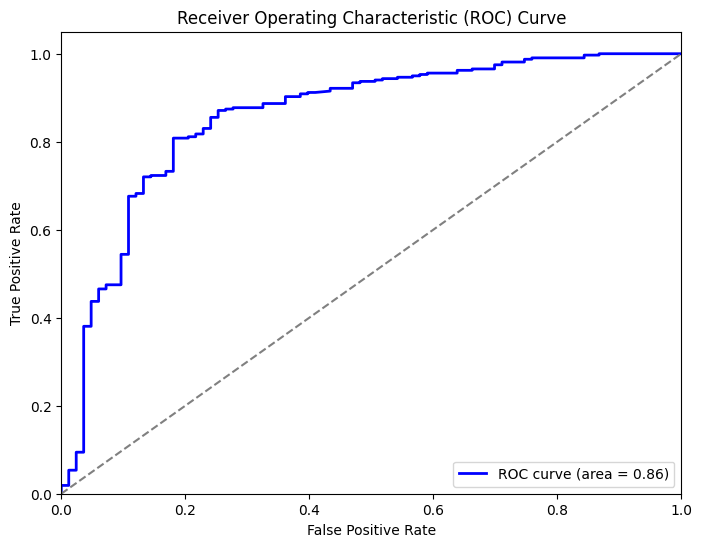


Evaluating Model for Entity: Perscription_Medications
Accuracy: 0.9576059850374065
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       381
           1       1.00      0.15      0.26        20

    accuracy                           0.96       401
   macro avg       0.98      0.57      0.62       401
weighted avg       0.96      0.96      0.94       401

Confusion Matrix:
[[381   0]
 [ 17   3]]
Confusion Matrix REORDERED:
[[381   0]
 [ 17   3]]


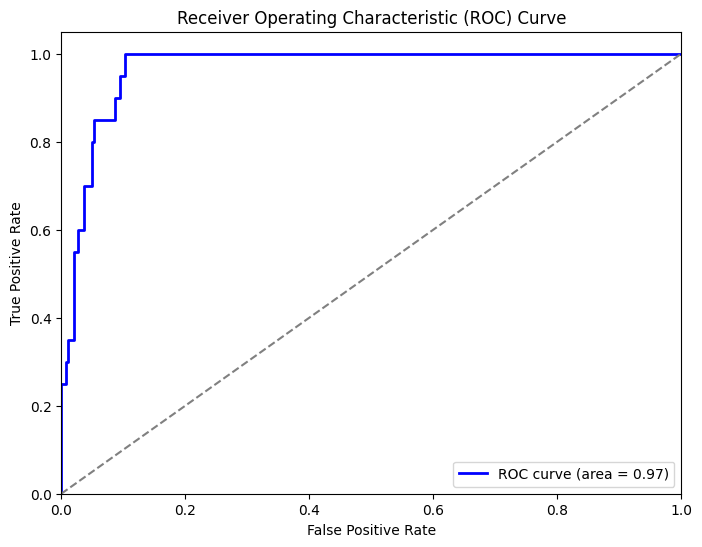


Evaluating Model for Entity: OTCs
Accuracy: 0.970074812967581
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       383
           1       1.00      0.33      0.50        18

    accuracy                           0.97       401
   macro avg       0.98      0.67      0.74       401
weighted avg       0.97      0.97      0.96       401

Confusion Matrix:
[[383   0]
 [ 12   6]]
Confusion Matrix REORDERED:
[[383   0]
 [ 12   6]]


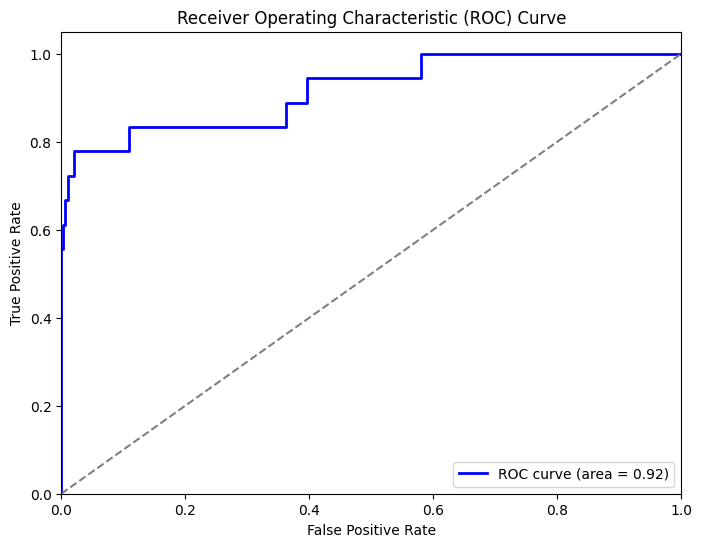


Evaluating Model for Entity: Substances
Accuracy: 0.9152119700748129
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       365
           1       0.67      0.11      0.19        36

    accuracy                           0.92       401
   macro avg       0.79      0.55      0.57       401
weighted avg       0.90      0.92      0.89       401

Confusion Matrix:
[[363   2]
 [ 32   4]]
Confusion Matrix REORDERED:
[[363   2]
 [ 32   4]]


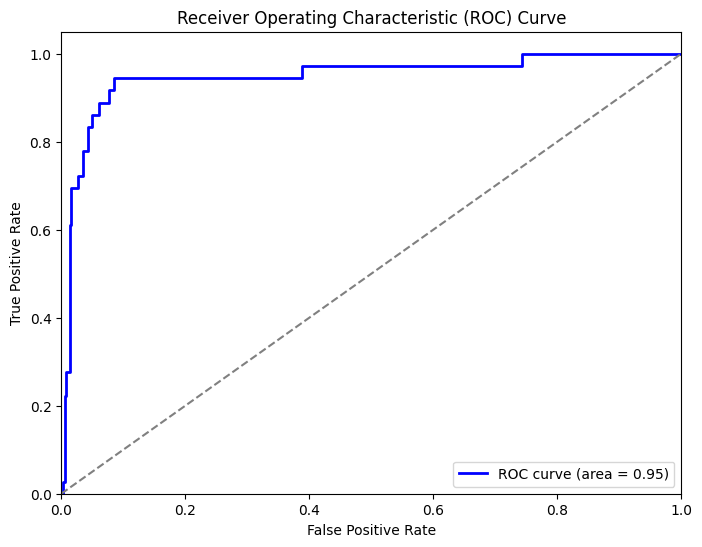


Evaluating Model for Entity: Anxiety
Accuracy: 0.9800498753117207
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       378
           1       0.86      0.78      0.82        23

    accuracy                           0.98       401
   macro avg       0.92      0.89      0.90       401
weighted avg       0.98      0.98      0.98       401

Confusion Matrix:
[[375   3]
 [  5  18]]
Confusion Matrix REORDERED:
[[375   3]
 [  5  18]]


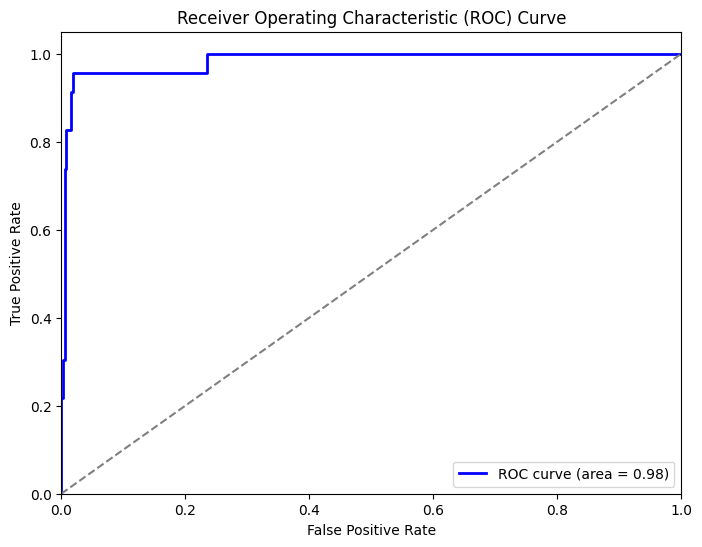


Evaluating Model for Entity: Depression
Accuracy: 0.972568578553616
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       378
           1       0.93      0.57      0.70        23

    accuracy                           0.97       401
   macro avg       0.95      0.78      0.84       401
weighted avg       0.97      0.97      0.97       401

Confusion Matrix:
[[377   1]
 [ 10  13]]
Confusion Matrix REORDERED:
[[377   1]
 [ 10  13]]


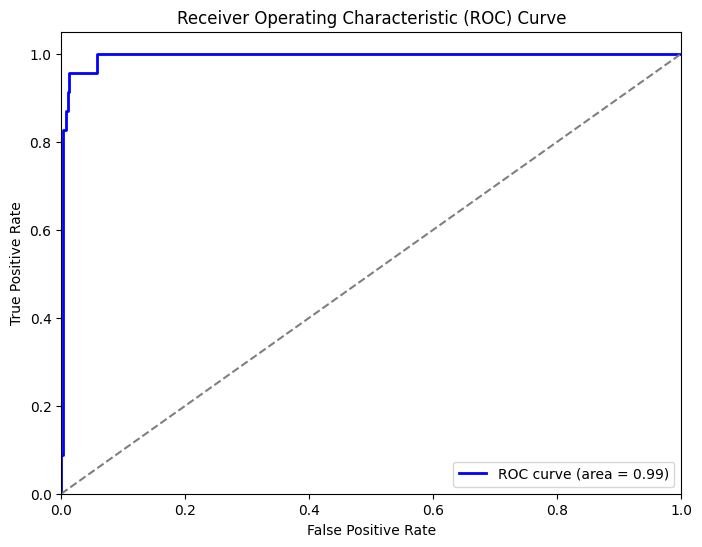


Evaluating Model for Entity: ADHD
Accuracy: 0.9501246882793017
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       338
           1       0.84      0.84      0.84        63

    accuracy                           0.95       401
   macro avg       0.91      0.91      0.91       401
weighted avg       0.95      0.95      0.95       401

Confusion Matrix:
[[328  10]
 [ 10  53]]
Confusion Matrix REORDERED:
[[328  10]
 [ 10  53]]


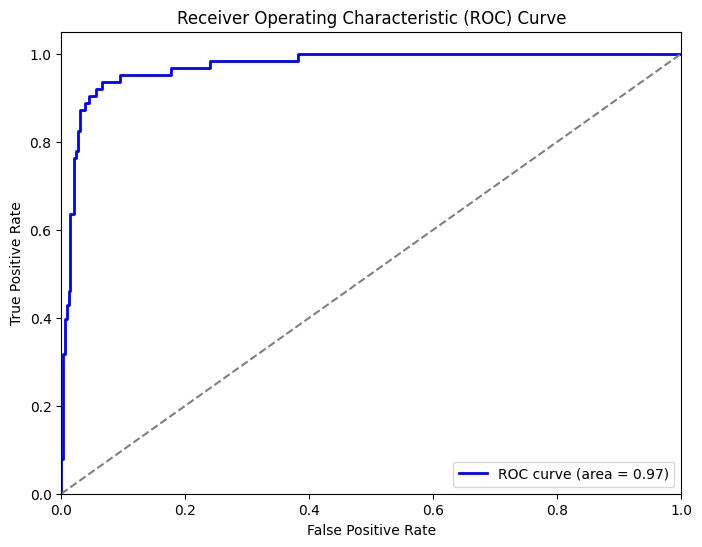


Evaluating Model for Entity: Other_Diagnoses
Accuracy: 0.9775561097256857
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       392
           1       0.00      0.00      0.00         9

    accuracy                           0.98       401
   macro avg       0.49      0.50      0.49       401
weighted avg       0.96      0.98      0.97       401

Confusion Matrix:
[[392   0]
 [  9   0]]
Confusion Matrix REORDERED:
[[392   0]
 [  9   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


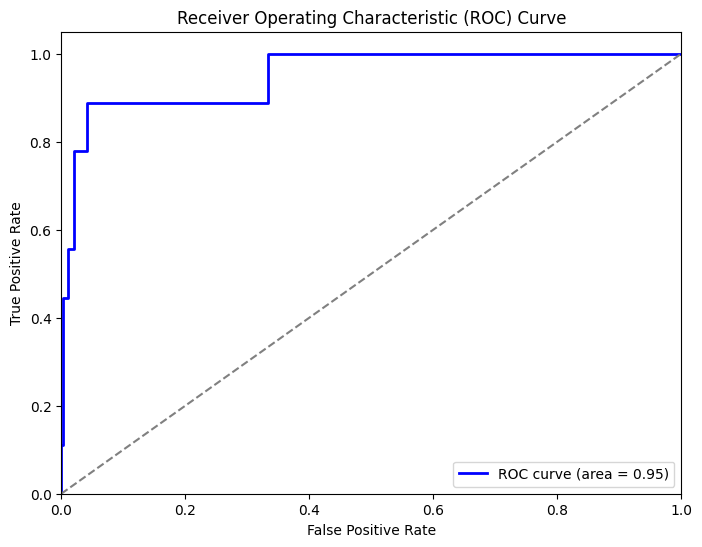

In [ ]:
for i in range(0,8):
  print("\nEvaluating Model for Entity: " + str(id_to_classes[i]))

  svm_classifier = SVC(kernel='linear', probability=True)
  svm_classifier.fit(feature_matrix, label_matrix[i])

  y_pred = svm_classifier.predict(feature_matrix_test)
  y_prob = svm_classifier.predict_proba(feature_matrix_test)[:, 1]

  print_evaluation_metrics(test_labels=label_matrix_test[i], y_pred=y_pred)
  plot_ROC(test_labels=label_matrix_test[i], y_prob=y_prob)